In [61]:
import sys
import pandas as pd
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.utils.timer import Timer
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
#from recommenders.datasets import movielens
from recommenders.utils.notebook_utils import is_jupyter
from recommenders.datasets.python_splitters import python_chrono_split,python_stratified_split
from recommenders.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k,
                                                     recall_at_k, get_top_k_items)

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))

System version: 3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]
Pandas version: 1.5.3
Tensorflow version: 2.16.1


In [62]:
# Top K items to recommend
TOP_K = 10

# Select MovieLens data size: 100k, 1m, 10m, or 20m
# MOVIELENS_DATA_SIZE = '100k'

# Model parameters
EPOCHS = 50
BATCH_SIZE = 256
SEED = 42

## 1. Load dataset

In [63]:
record_df = pd.read_csv('Data/Book/book_user_ratings.csv')
print(record_df.shape)
record_df.drop(columns=['age', 'gender', 'area'],inplace=True)
record_df.head()

(200122, 6)


,book_id,user_id,rating
0,248957,1397,5
1,248957,3357,5
2,248957,879,5
3,248957,1834,5
4,248957,2843,5


In [64]:
user_df = pd.read_csv('Data/Book/user_data.csv')
print(user_df.shape)
user_df.head()

(38370, 4)


,user_id,age,gender,nationality
0,1,37,Male,east_asian
1,2,37,Male,east_asian
2,3,37,Male,east_asian
3,4,37,Male,east_asian
4,5,37,Male,east_asian


In [65]:
book_df = pd.read_csv('Data/Book/datathriftle-book.csv')
print(book_df.shape)
book_df.head()

(10050, 13)


,book_id,title,description,book_cover,image_url,release_date,publisher,num_of_pages,price,authors,avg_rating,num_of_ratings,num_of_reviews
0,18599856,Where the Crawdads Sing,NOW A MAJOR MOTION PICTURE--The #1 New York Ti...,Paperback,https://i.thriftbooks.com/api/imagehandler/m/4...,0001-01-01T00:00:00,Corsair,303,14.39,Delia Owens,3.897698,391,95
1,248957,Harry Potter and the Sorcerer's Stone,The beloved first book of the Harry Potter ser...,Paperback,https://i.thriftbooks.com/api/imagehandler/m/9...,1998-09-01T00:00:00,Arthur A. Levine Books,320,4.29,J.K. Rowling,3.405858,239,38
2,247716,Nineteen Eighty-Four,"Written 75 years ago, 1984 was George Orwell's...",Paperback,https://i.thriftbooks.com/api/imagehandler/m/0...,0001-01-01T00:00:00,NaN,0,187.89,George Orwell,3.695279,233,24
3,248147,To Kill a Mockingbird,Voted America's Best-Loved Novel in PBS's The ...,Mass Market Paperback,https://img.thriftbooks.com/api/images/m/8594c...,1988-10-11T00:00:00,Grand Central Publishing,288,4.19,Harper Lee,3.548387,186,35
4,246270,The Alchemist,An international bestseller Over 80 million co...,Paperback,https://i.thriftbooks.com/api/imagehandler/m/1...,1993-04-25T00:00:00,HarperOne,197,5.49,Paulo Coelho,4.002950,339,27


In [66]:
record_df["book_id"] = record_df["book_id"].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
record_df["user_id"] = record_df["user_id"].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()

# dropping nulls
record_df = record_df.dropna()
record_df = record_df.drop_duplicates()
user_df = user_df.dropna()
user_df = user_df.drop_duplicates()
book_df = book_df.dropna()
book_df = book_df.drop_duplicates()

record_df = record_df.rename(columns={

    'user_id':"userID",'book_id':"itemID",'rating':"rating"

})

record_df["userID"] = record_df["userID"].astype(int)
record_df["itemID"] = record_df["itemID"].astype(int)

## 2. Split the data using the Spark chronological splitter provided in utilities

In [67]:
train, test = python_stratified_split(record_df, 0.75)

In [68]:
train_file = "Data/Book/train.csv"
test_file = "Data/Book/test.csv"
train.to_csv(train_file, index=False)
test.to_csv(test_file, index=False)

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146854 entries, 189329 to 54357
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   itemID  146854 non-null  int32
 1   userID  146854 non-null  int32
 2   rating  146854 non-null  int64
dtypes: int32(2), int64(1)
memory usage: 3.4 MB


## 3. Train the NCF model on the training data, and get the top-k recommendations for our testing data
NCF accepts implicit feedback and generates prospensity of items to be recommended to users in the scale of 0 to 1. A recommended item list can then be generated based on the scores. Note that this quickstart notebook is using a smaller number of epochs to reduce time for training. As a consequence, the model performance will be slighlty deteriorated.

In [69]:
data = NCFDataset(train_file=train_file, test_file=test_file, seed=SEED)

INFO:recommenders.models.ncf.dataset:Indexing Data/Book/train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing Data/Book/test.csv ...
INFO:recommenders.models.ncf.dataset:Creating full leave-one-out test file Data/Book/test_full.csv ...
100%|██████████| 4659/4659 [00:55<00:00, 84.63it/s] 
INFO:recommenders.models.ncf.dataset:Indexing Data/Book/test_full.csv ...


In [70]:
model = NCF (
    n_users=data.n_users,
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

c:\Users\minhh\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [71]:
with Timer() as train_time:
    model.fit(data)
print("Took {} seconds for training.".format(train_time))

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [21.99s]: train_loss = 0.351493 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [19.39s]: train_loss = 0.328393 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [18.32s]: train_loss = 0.316550 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [18.02s]: train_loss = 0.308754 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [18.43s]: train_loss = 0.302777 


Took 1028.4226 seconds for training.


In [245]:
model.save("Data/Book/ncf_model.h5")

### Load the model

In [247]:
data = NCFDataset(train_file=train_file, test_file=test_file, seed=SEED)
model = NCF (
    n_users=data.n_users,
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)
model.load(neumf_dir="Data/Book/ncf_model.h5")
model.user2id = data.user2id
model.item2id = data.item2id
model.id2user = data.id2user
model.id2item = data.id2item

INFO:recommenders.models.ncf.dataset:Indexing Data/Book/train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing Data/Book/test.csv ...
INFO:recommenders.models.ncf.dataset:Indexing Data/Book/test_full.csv ...
c:\Users\minhh\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [80]:
record_df = pd.read_csv('Data/Book/book_user_ratings.csv')
print(record_df.shape)
record_df.drop(columns=['age', 'gender', 'area'],inplace=True)
record_df.head()

(200122, 6)


,book_id,user_id,rating
0,248957,1397,5
1,248957,3357,5
2,248957,879,5
3,248957,1834,5
4,248957,2843,5


In [81]:
with Timer() as test_time:
    users, items, preds = [], [], []
    item = list(train.itemID.unique())
    for user in train.userID.unique():
        user = [user] * len(item)
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time))

Took 440.7796 seconds for prediction.


In [94]:
all_predictions.head()

,itemID,userID,prediction
146854,247237,1,0.360459
146855,11594325,1,0.013068
146856,246698,1,0.307931
146857,260787,1,0.633672
146858,339611,1,0.138012


## 4. Evaluate how well NCF performs
The ranking metrics are used for evaluation.

In [82]:
eval_map = map_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.004779
NDCG:	0.023262
Precision@K:	0.020326
Recall@K:	0.013617


In [116]:
all_predictions[all_predictions['userID']==1000].nlargest(30,'prediction')

,itemID,userID,prediction
9429152,248655,1000,0.906581
9429282,247716,1000,0.897887
9429143,249355,1000,0.888623
9429090,246270,1000,0.887918
9429513,3134922,1000,0.883315
9429116,14572273,1000,0.879643
9429906,18599856,1000,0.872772
9430444,248957,1000,0.870521
9429091,246787,1000,0.869078
9430903,27147994,1000,0.857085


## 5. Recommendation

In [114]:
def recommend_product_for_user(user_id):
    print(" \n---------- Top 10 Rating Books -----------\n")
    top_10_rating_books = record_df[record_df['user_id']==user_id].nlargest(10,'rating')
    print(top_10_rating_books)
    print('\n-------- Top 10 Rating Book Detail --------\n')
    print(book_df[book_df['book_id'].isin(top_10_rating_books['book_id'])][["title", "description"]].head())

    print("\n---------- Top 10 Recommended Books -----------\n")
    top_10_recommended_books = all_predictions[all_predictions['userID']==user_id].nlargest(10,'prediction')
    print(top_10_recommended_books)
    print('\n-------- Top 10 Recommended Book Detail --------\n')
    print(book_df[book_df['book_id'].isin(top_10_recommended_books['itemID'])][["title", "description"]].head())

In [185]:
recommend_product_for_user(1000)

 
---------- Top 10 Rating Books -----------

        book_id  user_id  rating
3637     246186     1000       5
4142     247949     1000       5
4451     248654     1000       5
5856     245736     1000       5
9898     246027     1000       5
11599    248345     1000       5
23418    249030     1000       5
26390    261057     1000       5
33719  29333096     1000       5
35165    245734     1000       5

-------- Top 10 Rating Book Detail --------

                         title  \
17  Animal Farm: A Fairy Story   
23          Rich Dad, Poor Dad   
24                    Twilight   
34             Brave New World   
69                     Hatchet   

                                          description  
17  75th Anniversary Edition--Includes a New Intro...  
23  April of 2022 marks a 25-year milestone for th...  
24  When Isabella Swan moves to the gloomy town of...  
34  The astonishing novel Brave New World, origina...  
69  This award-winning contemporary classic is the...  

---

## 6. Elastic Search

### 6.1. Trich xuat dac trung bang LDA

In [128]:
# Tiền xử lý dữ liệu
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
import re

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text) # Xóa các ký tự đặc biệt
    text = text.lower() # Chuyển văn bản thành chữ thường
    text = ' '.join([word for word in text.split() if word not in stop_words]) # Loại bỏ stopwords
    return text

preprocessed_book_desc = book_df['description'].apply(preprocess_text)
corpus = preprocessed_book_desc.tolist()
print(preprocessed_book_desc)

0        major motion picturethe 1 new york times bests...
1        beloved first book harry potter series fully i...
3        voted americas bestloved novel pbss great amer...
4        international bestseller 80 million copies sol...
5        stunning new edition jk rowlings harry potter ...
                               ...                        
10044    billy little boy loved horses anything else wo...
10045    fresh look infidelity broadening focus havoc w...
10046    fouryearolds makes lovable problems fouryearol...
10047    encourage read book asking great things god da...
10049    course designed last science course student ta...
Name: description, Length: 9813, dtype: object


In [220]:
# Chuyển đổi văn bản thành vector sử dụng TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

# Huấn luyện mô hình LDA

num_topics = 20
lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda.fit(X)

# Trích xuất đặc trưng từ mô hình LDA
topic_distribution = lda.transform(X)

# Chọn chủ đề có xác suất cao nhất cho mỗi mô tả sách
book_topics = topic_distribution.argmax(axis=1)

# Gán mỗi mô tả vào chủ đề tương ứng
book_df['topic'] = book_topics

In [221]:
# Luu book_df with topic vao file csv
# book_df.to_csv('Data/Book/book_topic.csv', index=False)
topic_counts = book_df['topic'].value_counts()
print(topic_counts)

4     8153
8     1341
1       94
6       36
7       20
0       16
3       16
17      16
18      14
9       13
12      13
15      12
16      12
10      11
5       10
11       9
14       9
13       7
2        6
19       5
Name: topic, dtype: int64


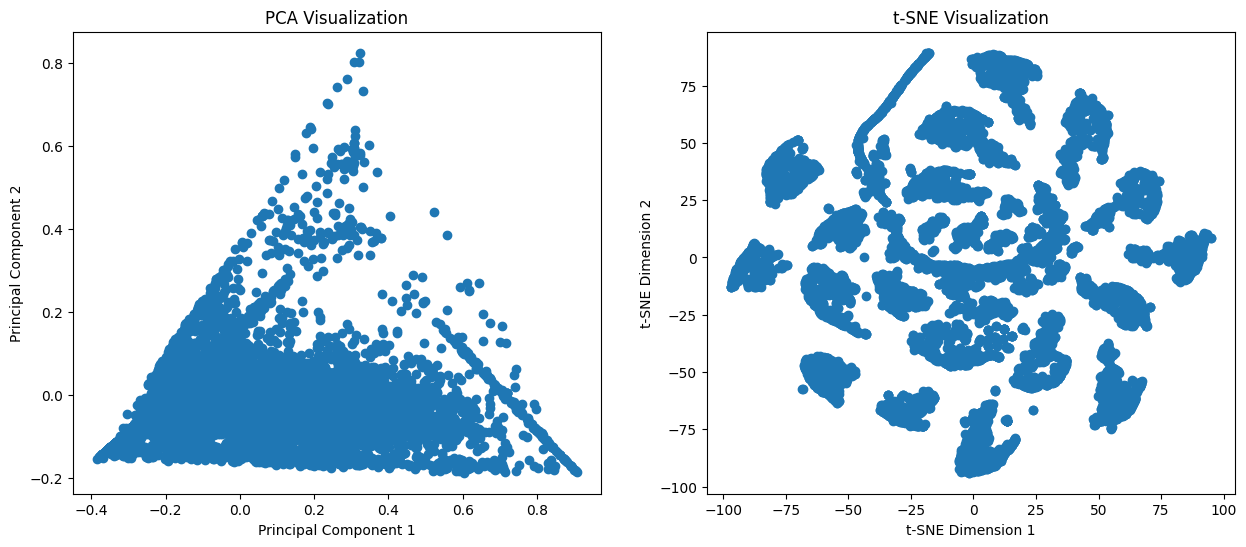

In [222]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Giảm chiều dữ liệu bằng PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(topic_distribution)  # Sử dụng topic_distribution từ mô hình LDA

# Tạo figure và hai subplot
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Vẽ PCA Visualization
axs[0].scatter(X_pca[:, 0], X_pca[:, 1])
axs[0].set_title('PCA Visualization')
axs[0].set_xlabel('Principal Component 1')
axs[0].set_ylabel('Principal Component 2')

# Vẽ t-SNE Visualization
axs[1].scatter(X_tsne[:, 0], X_tsne[:, 1])
axs[1].set_title('t-SNE Visualization')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')

plt.show()

In [243]:
def recommend_books_based_on_topic(user_id, topic_distribution, num_books_to_recommend=10):
    print(" \n---------- Top 30 Rating Books (NCF) -----------\n")
    # Sắp xếp ma trận chứa xác suất chủ đề giảm dần theo từng hàng
    top_topic_indices = np.argsort(-topic_distribution, axis=1)[0]
    top_topic_indices_df = pd.DataFrame(top_topic_indices)
    top_topic_indices_df = top_topic_indices_df.rename(columns={0: 'topic'})

    # Hiển thị DataFrame kết quả


    # Tạo một danh sách chứa các chỉ số của các sách được đề xuất từ mô hình NCF
    top_books_recommended_NCF = all_predictions[all_predictions['userID'] == user_id].nlargest(30, 'prediction')

    # Duyệt qua danh sách các sách được đề xuất từ mô hình NCF và sắp xếp chúng theo cột chủ đề tương ứng
    top_books_recommended_NCF_data = pd.merge(top_books_recommended_NCF, book_df, left_on="itemID", right_on="book_id", how= "inner", sort=False)[["book_id", "title", "description", "topic"]]


    print(top_books_recommended_NCF_data)
    print(top_topic_indices_df)

    # Sắp xếp top_books_recommended_NCF_data bằng top_topic_indices
    print(" \n---------- Top 10 Recommended Books (After LDA) -----------\n")
    # top_books_recommended_NCF_data_sorted = top_books_recommended_NCF_data.iloc[top_topic_indices].sort_values(by="topic")
    top_books_recommended_NCF_data_sorted = pd.merge(top_topic_indices_df, top_books_recommended_NCF_data, on="topic", how= "inner", sort=False)

    return top_books_recommended_NCF_data_sorted[:num_books_to_recommend]

In [244]:
# Gợi ý sách cho người dùng dựa trên topic của họ
user_topic_distribution = lda.transform(vectorizer.transform(["New York Times bestselling author"]))
recommended_books = recommend_books_based_on_topic(1000, user_topic_distribution)
print(recommended_books)

 
---------- Top 30 Rating Books (NCF) -----------

     book_id                                              title  \
0     248655  The Four Agreements: A Practical Guide to Pers...   
1     249355            How to Win Friends and Influence People   
2     246270                                      The Alchemist   
3    3134922                        All the Light We Cannot See   
4   14572273                                           Educated   
5   18599856                            Where the Crawdads Sing   
6     248957              Harry Potter and the Sorcerer's Stone   
7     246787                                     The Book Thief   
8   27147994                          The Last Thing He Told Me   
9     248285                                Pride and Prejudice   
10  13536370                               Before We Were Yours   
11  14102080  Boundaries: When to Say Yes, How to Say No to ...   
12    248147                              To Kill a Mockingbird   
13    2468